# Header: Forward modeling of the HT-ATES site (version 1)

**Research setting: hot water is injected into a shallow aquifer at the HT-ATES site in Delft. We investigate the use of a surface-to-borehole CSEM monitoring set-up for recovering the shape of the hot plume that develops.**

**This code is based on the EASYGO summer school exercises: https://github.com/emsig/easygo-training-em/blob/main/emg3d_ATES.ipynb**

We want to compare forward-modeling results between:
- Empymod: analytic solutions which can be used to evaluate if the grid is dense enough
- EASYGO-based simulations in Emg3d presented here
- Results found with Elfe3d by Paula
- Changes in parameters based on Emg3d work by Mahmoud on the deeper geothermal well (Eltayieb, 2023)

## In this version

Using resistivity model based on the interpretation by Marco Bortollotti, and a hot plume generated through a COMSOL model for homogeneous aquifer. The hot plume parameters are not tailored to the site, and the plume was simply chosen because of its buoyant shape. The simulation time for the hot plume of (...) days was chosen because the hot plume would then be constrained in size so as to not reach the receivers in the borehole.

It will be of interest to see if there are changes in the measured signal at the receiver due to this hot plume that is not present at the receivers itself (a requirement for DTS-based monitoring). The source position will be varied to investigate when this change is the highest.

The receivers used in this forward-modeling are point-based receivers, which does not accurately represent the measurement. The real receivers will be of 0.5 m in length and spaced by 7.5 m. It was decided to implement the spacing (7.5 m) but not the size of the receivers for now.

## To be updated

In further notebooks, the resistivity model and plume will be updated to take into account various subsurface scenarios, including lateral and vertical heterogeneity as well as different degrees of buoyancy (governed by permeability of the aquifer). Plumes will be generated bia OpenDarts which can optimally take into account the reservoir heterogeneity, including differential flow into the different layers due to permeability differences. The plume and subsurface scenario will therefore be more realistic.

Additional investigations should include: comparison with surface-to-surface measurements, calculation of the sensitivity and inversion of synthetic data, investigation of the optimal combination of multiple sources, investigate impact of the production well steel casing and placing sources close to the production well (magnification of the source signal at depth), use of realistic source locations considering the site, effect of well-deviation and Ex component, effect of vertical sources in DTS wells

Empymod could be used to test if the size of the receivers makes a difference to the measurement. It would also be good to consider the capacitive coupling of the receivers and whether this makes a difference to the acquired signal.

# Code

In [1]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

plt.style.use('bmh')

# Comment this out on Google Colab
#%matplotlib widget

## Functions

In [2]:
#define interpolation functions
def find_distance2d(coord1, coord2):
    distance = (coord1[0]-coord2[0])**2+(coord1[1]-coord2[1])**2
    return distance
    #This is the distance squared but it should work the same

def interpolate2d(location, array):
    dis = []
    for i in np.arange(len(array)):
        dis.append(find_distance2d(location, array[i]))
    return np.argmin(dis)

In [119]:
print(grid.shape_cells[0]/2)

40.0


### Selecting cuboids from the grid

In [409]:
def point2index_xyz(grid, point, QC=False):
    #Assumes that 
    
    x_spacing = min(grid.h[0])
    y_spacing = min(grid.h[1])
    z_spacing = min(grid.h[2])

    grid_center_i = int((grid.n_cells+grid.shape_cells[0]*grid.shape_cells[1]+ grid.shape_cells[0])/2)
    grid_center =  grid.cell_centers[grid_center_i]

    ix_steps = int((point[0]-grid_center[0])/x_spacing)
    iy_steps = int((point[1]-grid_center[1])/y_spacing)
    iz_steps = int((point[2]-grid_center[2])/z_spacing)
    
    ix = int(grid.shape_cells[0]/2)+ix_steps
    iy = int(grid.shape_cells[1]/2)+iy_steps
    iz = int(grid.shape_cells[2]/2)+iz_steps

    if grid.h[0][int(grid.shape_cells[0]/2)] != x_spacing:
        print('Warning: no homogeneous x-spacing')
    if grid.h[1][int(grid.shape_cells[1]/2)] != y_spacing:
        print('Warning: no homogeneous y-spacing')
    if grid.h[2][int(grid.shape_cells[2]/2)] != z_spacing:
        print('Warning: no homogeneous z-spacing')

    if QC==True:
        print('x: ', grid.cell_centers_x[ix])
        print('y: ', grid.cell_centers_y[iy])
        print('z: ', grid.cell_centers_z[iz])

    return ix, iy, iz

In [330]:
def find_cuboid_indeces_xyz(grid, x_extent, y_extent, zmin, zmax, QC=True):

    cornerpoint1 = [-x_extent, -y_extent, zmin]
    cornerpoint2 = [x_extent, y_extent, zmax]

    if QC==True:
        print(cornerpoint1, cornerpoint2)
    
    ix_min, iy_min, iz_min = point2index_xyz(grid, cornerpoint1, QC=False)
    ix_max, iy_max, iz_max = point2index_xyz(grid, cornerpoint2, QC=False)

    return ix_min, iy_min, iz_min, ix_max, iy_max, iz_max

In [168]:
def change_cuboid_resistivity(res_orig, grid, x_extent, y_extent, zmin, zmax, target_res):
    #Assumes that cuboid will be created around x=0 and y=0
    #Only works for grids that are symmetric around the origin in the number of cells

    ix_min, iy_min, iz_min, ix_max, iy_max, iz_max = find_cuboid_indeces_xyz(x_extent, y_extent, zmin, zmax)

    #QC the bounds
    print('x bounds: ', grid.cell_centers_x[ix_min], ' , ', grid.cell_centers_x[ix_max])
    print('y_bounds: ', grid.cell_centers_y[iy_min], ' , ', grid.cell_centers_y[iy_max])
    print('z_bounds: ', grid.cell_centers_z[iz_min], ' , ', grid.cell_centers_z[iz_max])

    # Set target resistivity of the cuboid
    res_new = res_orig
    res_new[ix_min:ix_max, iy_min:iy_max, iz_min:iz_max] = target_res

    return res_new

### Manual plotting of values (vs. plot_slice)
This is done to enable comparison with empymod

To compare with empymod, we crop the field values to the inner domain by finding the boundary indeces.
Note: we can only use the inner domain where no cell stretching is taking place: y = [-300, 300], z = [-250, -5] & cell width is constant

Note about plotting:

When using plot_slice, the simulation output is interpolated to the cell centers, which results in a slightly different plot than when the output is directly plotted using matplotlib. Especially beneath the source this is visible, as the field value should be 0 there but this is not shown if the field value is not sampled (or interpolated) to that exact point.

I have chosen here to use the matplotlib plotting, and to accept the inaccuracy below the source, as this makes it easier to compare results between emg3d and empymod

In [339]:
def crop_to_domain(efield3D, grid, x_slice = 0, y_extent=300, zmin=-250, zmax=0):

    #This method assumes cell_centers are the relevant parameters
    ix_min, iy_min, iz_min, ix_max, iy_max, iz_max = find_cuboid_indeces_xyz(grid, x_slice, y_extent, zmin, zmax, QC=True)

    #QC the bounds
    print('x position: ', grid.nodes_x[ix_max])
    print('y_bounds: ', grid.nodes_y[iy_min], ' , ', grid.nodes_y[iy_max+1])
    print('z_bounds: ', grid.cell_centers_z[iz_min], ' , ', grid.cell_centers_z[iz_max])

    # Crop Ez field array
    crop_efield3D = efield3D.fz[ix_max, iy_min:iy_max+2, iz_min:iz_max+1]
    crop_efield3D = np.flip(np.transpose(crop_efield3D), axis=0)

    return crop_efield3D

In [321]:
def manual_plot_slice(efield, grid, y_extent=300, zmin=-250, zmax=0, size_y = 6.4, size_z = 4.8, vmin = 1e-7, vmax = 1e-6, norm = 'log'):
    
    fig, ax = plt.subplots()
    plt.imshow(np.abs(efield), extent = [0, size_y, 0, size_z], norm=norm, vmin = vmin, vmax = vmax)
    ax.set_title('Field')
    #ax.set_xlabel('Offset (km)')
    #ax.set_ylabel('Depth (1e2 m)')
    plt.colorbar(location='right', fraction=0.035)
    plt.xticks(np.arange(0, size_y, size_y/4), np.arange(-y_extent, y_extent, y_extent/2))
    plt.yticks(np.arange(0, size_z, size_z/4), np.arange(zmin, zmax, (zmax-zmin)/4))
    plt.grid(False)
    plt.show()

In [285]:
def manual_plot_slice_3x(efield1, efield2, efield3, y_extent=-300, zmin=-250, zmax=0, size_y = 6.4, size_z = 4.8, vmin = 1e-8, vmax = 1e-4):

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

    ax1_plot = ax1.imshow(np.abs(efield1), extent = [0, size_y, 0, size_z], norm='log', vmin = vmin, vmax = vmax)
    ax1.set_title('Field 1 |Ez| (V/m)')
    ax1.set_xlabel('y (m)')
    ax1.set_ylabel('z (m)')
    plt.colorbar(ax1_plot, location='bottom')
    ax1.set_xticks(np.arange(0, size_y, size_y/4), np.arange(-y_extent, y_extent, y_extent/2))
    ax1.set_yticks(np.arange(0, size_z, size_z/4), np.arange(zmin, zmax, (zmax-zmin)/4))
    ax1.grid(False)
    
    ax2_plot = ax2.imshow(np.abs(efield2), extent = [0, size_y, 0, size_z], norm='log', vmin = vmin, vmax = vmax)
    ax2.set_title('Field 2 |Ez| (V/m)')
    ax2.set_xlabel('y (m)')
    ax2.set_ylabel('z (m)')
    plt.colorbar(ax2_plot, location='bottom')
    ax2.set_xticks(np.arange(0, size_y, size_y/4), np.arange(-y_extent, y_extent, y_extent/2))
    ax2.set_yticks(np.arange(0, size_z, size_z/4), np.arange(zmin, zmax, (zmax-zmin)/4))
    ax2.grid(False)
    
    ax3_plot = ax3.imshow(np.abs(efield3), extent = [0, size_y, 0, size_z], norm='log', vmin = vmin, vmax = vmax)
    ax3.set_title('Field 3 |Ez| (V/m)')
    ax3.set_xlabel('y (m)')
    ax3.set_ylabel('z (m)')
    plt.colorbar(ax3_plot, location='bottom')
    ax3.set_xticks(np.arange(0, size_y, size_y/4), np.arange(-y_extent, y_extent, y_extent/2))
    ax3.set_yticks(np.arange(0, size_z, size_z/4), np.arange(zmin, zmax, (zmax-zmin)/4))
    ax3.grid(False)

## Construct survey, grid and baseline model

- The hot plume is centred at x=0, y=0
- Source and receiver are 200 m away (y_s=-126 and y_r=74)
- Depth is negative!

In [380]:
# Source
source = [0, -126, 0, 90.0, 0] # y-directed point dipole on the surface

# Source frequency
frequency = 1

# Receiver offsets
offsets = np.arange(0, 300, 7.5)  # 300 m long receiver line

# receiver-array: x, y, z, azimuth, dip
receivers = (offsets*0, [74]*len(offsets), -offsets, 0, 90)  # z-directed, Ez response

# Layer boundaries
# We idealize the depth model here a bit, to have cells of 10m in depth
depth = [0, -50, -80, -120, -190]

# Layer resistivities in Ohm.m for the baseline
resistivities_base = np.array([1e8, 52.0, 38.0, 26.0, 29.5, 17.5]) # base incl. air (lower res, because of 3D modelling)


In [13]:
# define the input that stays the same for all models
inp = {
    'src': source,
    'rec': receivers,
    'depth': depth,
    'freqtime': frequency,
    'srcpts': 5,  # Models the finite-length source as 5 point sources with Gaussian Quadrature
    'htarg': {'pts_per_dec': -1},  # Faster computation
    'verb': 1,
    'strength': 1,
}

In [14]:
grid = emg3d.construct_mesh(
    center=(0,0,0),                                 # Center of wanted grid
    frequency=frequency,                            # Frequency we will use the grid for
    properties=[25, 1e8],                           # Reference resistivity
    domain=([-150, 150], [-300, 300], [-250, 0]),   # Domain in which we want precise results
    center_on_edge=True,
    min_width_limits = [10, 10, 5],
)
 
grid  # mesh info
#grid.plot_grid() # plotting the grid

TensorMesh: 983,040 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     80   -103,135.26    103,135.26     10.00 28,028.05    1.37
   y    128   -105,016.88    105,016.88     10.00 21,122.27    1.25
   z     96   -105,145.43    156,825.85      5.00 51,925.42    1.49

In [96]:
#Insert resistivity values into the grid

# Pre-allocate an array with number of cells corresponding to our grid
res_base = np.ones(grid.shape_cells)

# Layered base model: Fill in layered resistivities into our grid and create model
dd = np.r_[np.inf, depth, -np.inf]
for i in range(len(resistivities_base)):
    res_base[:, :, (grid.cell_centers_z > dd[i+1]) & (grid.cell_centers_z <= dd[i])] = resistivities_base[i]

model_base = emg3d.Model(grid, property_x=res_base, mapping='Resistivity')

## Simulation of baseline model

### Empymod simulation

In [379]:
# Empymod response over the whole domain

# Receiver depths, this should be at the z-coordinates of grid cell centers
rcv_depths = np.arange(2.5, 252.5,5)
# Receiver offsets, this should be at the x,y-coordinates of grid edegs
offsets2 = np.arange(-300,310,10)

Ez_Empy_base = np.zeros((len(rcv_depths), len(offsets)))

for i in np.arange(len(rcv_depths)):
    # z-directed dipole receiver-array: x, y, z, azimuth, dip
    emp_receivers = [[0]*len(offsets2), offsets2, -rcv_depths[i], 0, 90.0]
    efield = empymod.bipole(
            src=source,
            rec=emp_receivers,
            depth=depth,
            res=resistivities_base,
            freqtime=frequency,
            verb=0,
    )
    Ez_Empy_base[i,:] = efield.amp()

In [376]:
#Receiver line respone
resp_E_base = empymod.bipole(res=resistivities_base, **inp)

### Emg3d simulation

Takes +/- 17 minutes

In [183]:
# Generate source field
sfield = emg3d.fields.get_source_field(grid, source=source, frequency=frequency)

In [184]:
# Baseline model
efield3D_base = emg3d.solve(model_base, sfield, verb=2)

:: emg3d :: 1.2e-06; 4(27); 0:17:08; CONVERGED


In [186]:
# Get receiver line response
resp_E_base_3D = efield3D_base.get_receiver(receivers, 'linear')

### Plots

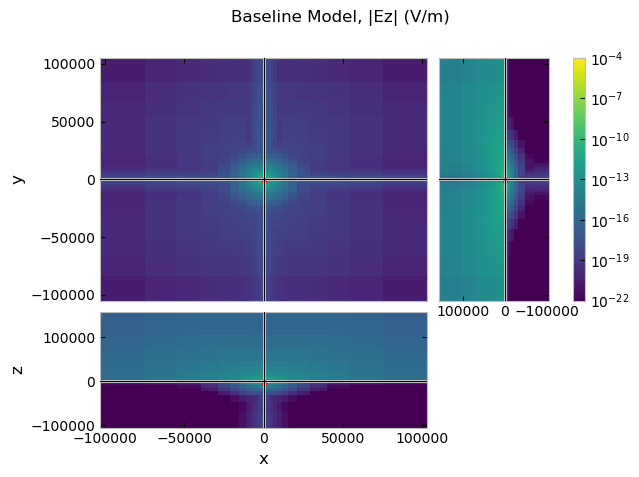

In [193]:
#Plot in the entire domain

grid.plot_3d_slicer(
    efield3D_base.fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-22, vmax=1e-4)},
    zslice = -160
)
fig = plt.gcf()
fig.suptitle('Baseline Model, |Ez| (V/m)')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

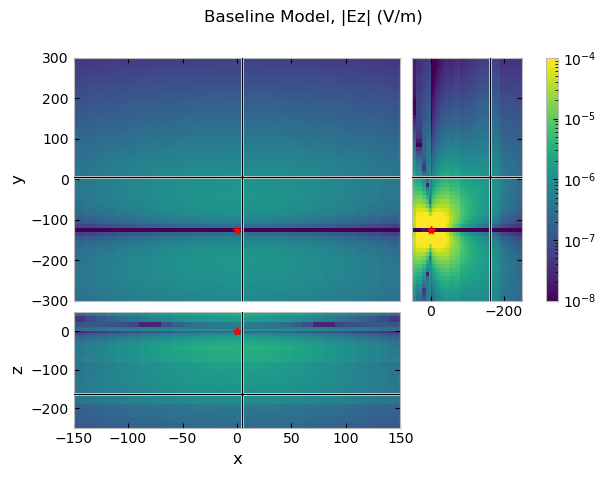

In [194]:
#Plot in the inner domain

grid.plot_3d_slicer(
    efield3D_base.fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-4)},
    xlim=[-150, 150],
    ylim=[-300, 300],
    zlim=[-250, 50],
    zslice=-160,
)
# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Baseline Model, |Ez| (V/m)')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

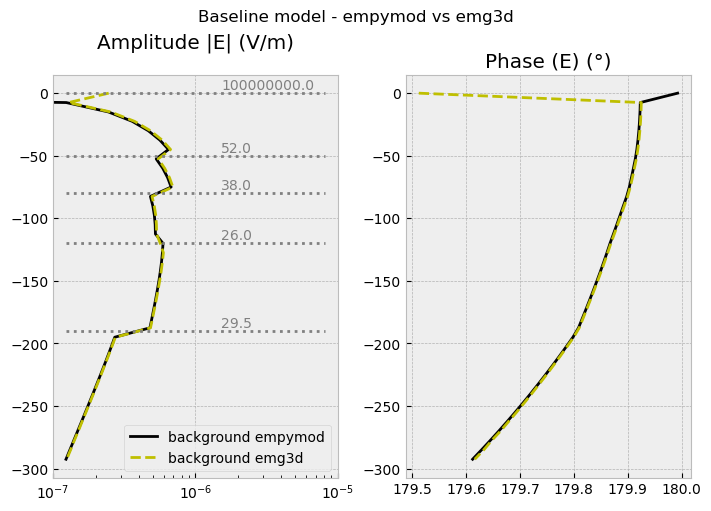

In [216]:
# Plot receiver line responses
fig3, (ax31, ax32) = plt.subplots(1, 2, figsize=(7, 5), constrained_layout=True)

fig3.suptitle("Baseline model - empymod vs emg3d")

ax31.set_title('Amplitude |E| (V/m)')
ax31.plot(resp_E_base.amp(), -offsets, 'k', label='background empymod')
ax31.plot(resp_E_base_3D.amp(), -offsets, 'y--', label='background emg3d') # scale your emg3d amplitues by the source length
ax31.set_xscale('log')
ax31.set_xlim([1e-7, 1e-5])
ax31.legend()

ax32.set_title('Phase (E) (°)')
ax32.plot(resp_E_base.pha(deg=True), -offsets, 'k')
ax32.plot(resp_E_base_3D.pha(deg=True), -offsets, 'y--')

ax33 = ax31.twiny()
#ax33.set_title('Model rho (Ohmm)')
#ax33.plot([75, 52.0, 52.0, 38.0, 38.0, 26.0, 26.0, 29.5, 29.5, 17.5, 17.5], [0, 0, -50, -50, -80, -80, -120, -120, -190, -190, -300], 'gray', ls='-')
ax33.hlines(depth, 0, 1, color='gray', ls=':', zorder=-1)
for i in np.arange(len(depth)):
    ax33.text(0.6, depth[i]+3, str(resistivities_base[i]), color='gray')
ax33.set_axis_off()

[0, -300, -250] [0, 300, 0]
x position:  -1.759303813742008e-11
y_bounds:  -299.99999999999443  ,  300.00000000000557
z_bounds:  -247.49999999999577  ,  -2.499999999995765


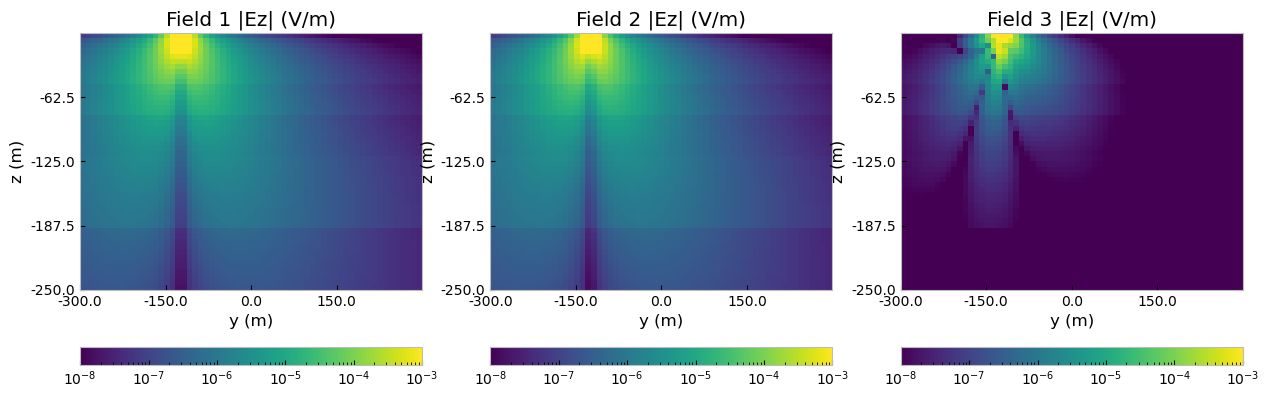

In [340]:
#plot to add: emg3d vs. empymod + difference

efield1 = crop_to_domain(efield3D_base, grid, x_slice = 0, y_extent=300, zmin=-250, zmax=0)
efield2 = Ez_Empy_base
efield3 = np.abs(efield2)-np.abs(efield1)

manual_plot_slice_3x(efield1, efield2, efield3, y_extent=300, zmin=-250, zmax=0, size_y = 6.4, size_z = 4.8, vmin = 1e-8, vmax = 1e-3)

## Simulation of layered 1D plume model

This test is done to test the effect of the used grid on model accuracy

### Create target model

In [217]:
# Create target models

# Layer resistivities in Ohm.m for the target model
resistivities_target = resistivities_base.copy()
res_target = 13.1
resistivities_target[4] = res_target  # adjust target resistivity (second last), now: aquifer +50 °Celsius

# Layered target model: Fill in layered resistivities into our grid and create model
res_target1 = res_base.copy()
dd = np.r_[np.inf, depth, -np.inf]
for i in range(len(resistivities_target)):
    res_target1[:, :, (grid.cell_centers_z > dd[i+1]) & (grid.cell_centers_z <= dd[i])] = resistivities_target[i]

model_target1 = emg3d.Model(grid, property_x=res_target1, mapping='Resistivity')

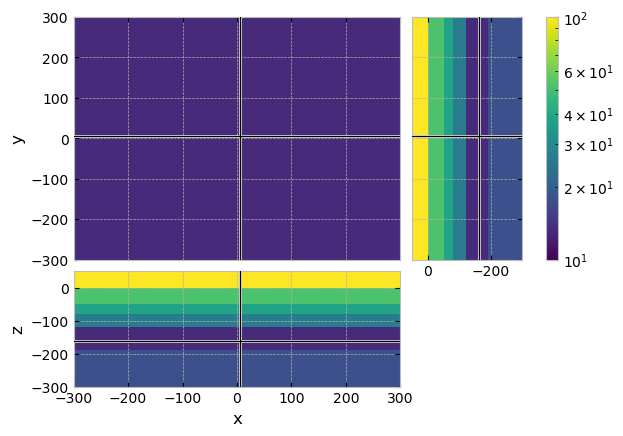

In [219]:
#QC model
grid.plot_3d_slicer(
    model_target1.property_x,
    pcolor_opts={'norm': LogNorm(vmin=10, vmax=100)},
    xlim=[-300, 300],
    ylim=[-300, 300],
    zlim=[-300, 50],
    zslice=-160,
)
fig = plt.gcf()

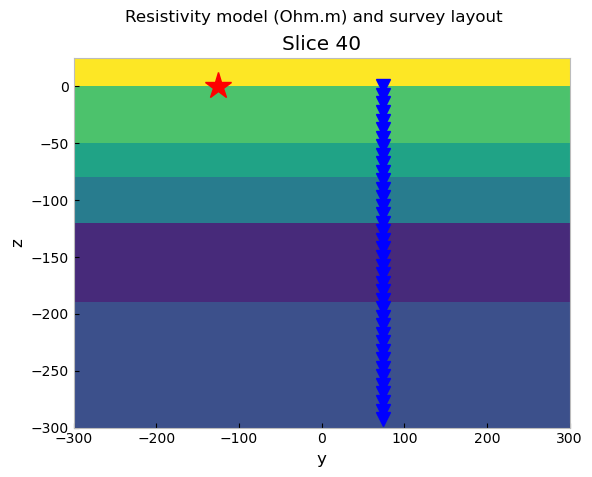

In [220]:
#Focus on the y,z plane
grid.plot_slice(
    model_target1.property_x,
    normal = 'X',
    pcolor_opts={'norm': LogNorm(vmin=10, vmax=100)},
    range_x=[-300, 300],
    range_y=[-300, 25],
#    slice_loc=0
)
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
axs[1].plot(rec_coords[1], rec_coords[2], 'bv', markersize = 10)
axs[1].plot(src_coords[1], src_coords[2], 'r*', markersize = 20)
axs[1].grid(False)

### Empymod simulation

In [232]:
resp_E_target1 = empymod.bipole(res=resistivities_target, **inp)

### Emg3d simulation

Takes +/- 17 minutes

In [222]:
# Generate source field
sfield = emg3d.fields.get_source_field(grid, source=source, frequency=frequency)

In [224]:
# Simulate for layered target
efield3D_target1 = emg3d.solve(model_target1, sfield, verb=2)

:: emg3d :: 1.4e-06; 4(27); 0:17:58; CONVERGED


In [230]:
# Layered base
resp_E_target1_3D = efield3D_target1.get_receiver(receivers, 'linear')

### Plots

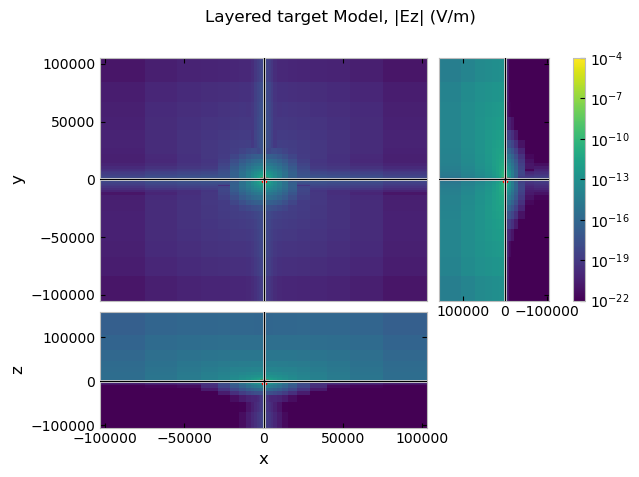

In [246]:
#Plot in the entire domain

grid.plot_3d_slicer(
    efield3D_target1.fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-22, vmax=1e-4)},
    zslice = -160
)
fig = plt.gcf()
fig.suptitle('Layered target Model, |Ez| (V/m)')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

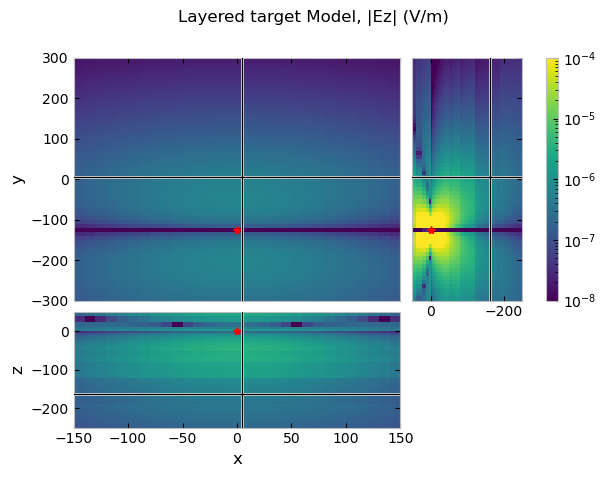

In [247]:
#Plot in the inner domain

grid.plot_3d_slicer(
    efield3D_target1.fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-4)},
    xlim=[-150, 150],
    ylim=[-300, 300],
    zlim=[-250, 50],
    zslice=-160,
)
# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Layered target Model, |Ez| (V/m)')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

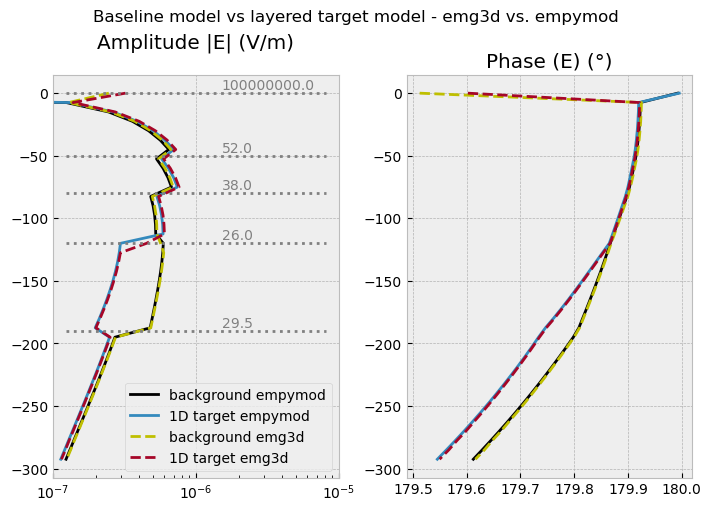

In [236]:
# Plot it
fig3, (ax31, ax32) = plt.subplots(1, 2, figsize=(7, 5), constrained_layout=True)

fig3.suptitle("Baseline model vs layered target model - emg3d vs. empymod")

ax31.set_title('Amplitude |E| (V/m)')
ax31.plot(resp_E_base.amp(), -offsets, 'k', label='background empymod')
ax31.plot(resp_E_target1.amp(), -offsets, 'C0-', label='1D target empymod')
ax31.plot(resp_E_base_3D.amp(), -offsets, 'y--', label='background emg3d') # scale your emg3d amplitues by the source length
ax31.plot(resp_E_target1_3D.amp(), -offsets, 'C1--', label='1D target emg3d') # scale your emg3d amplitues by the source length
ax31.set_xscale('log')
ax31.set_xlim([1e-7, 1e-5])
ax31.legend()

ax32.set_title('Phase (E) (°)')
ax32.plot(resp_E_base.pha(deg=True), -offsets, 'k')
ax32.plot(resp_E_target1.pha(deg=True), -offsets, 'C0-')
ax32.plot(resp_E_base_3D.pha(deg=True), -offsets, 'y--')
ax32.plot(resp_E_target1_3D.pha(deg=True), -offsets, 'C1--')

ax33 = ax31.twiny()
#ax33.set_title('Model rho (Ohmm)')
#ax33.plot([75, 52.0, 52.0, 38.0, 38.0, 26.0, 26.0, 29.5, 29.5, 17.5, 17.5], [0, 0, -50, -50, -80, -80, -120, -120, -190, -190, -300], 'gray', ls='-')
ax33.hlines(depth, 0, 1, color='gray', ls=':', zorder=-1)
for i in np.arange(len(depth)):
    ax33.text(0.6, depth[i]+3, str(resistivities_base[i]), color='gray')
ax33.set_axis_off()

[0, -300, -250] [0, 300, 0]
x position:  -1.759303813742008e-11
y_bounds:  -299.99999999999443  ,  290.00000000000557
z_bounds:  -247.49999999999577  ,  -2.499999999995765
[0, -300, -250] [0, 300, 0]
x position:  -1.759303813742008e-11
y_bounds:  -299.99999999999443  ,  290.00000000000557
z_bounds:  -247.49999999999577  ,  -2.499999999995765


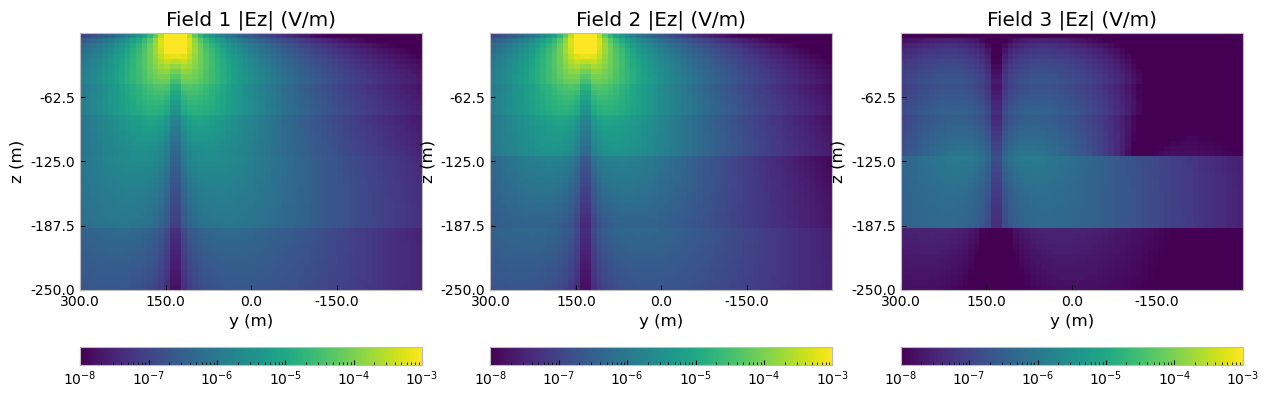

In [308]:
#Layered plume model

efield1 = crop_to_domain(efield3D_base, grid, x_slice = 0, y_extent=300, zmin=-250, zmax=0)
efield2 = crop_to_domain(efield3D_target1, grid, x_slice = 0, y_extent=300, zmin=-250, zmax=0)
efield3 = np.abs(efield2)-np.abs(efield1)

manual_plot_slice_3x(efield1, efield2, efield3, y_extent=-300, zmin=-250, zmax=0, size_y = 6.4, size_z = 4.8, vmin = 1e-8, vmax = 1e-3)

## Simulation of cubic plume model

### Create target model

In [240]:
#Use predefined function to insert a cuboid inton the target layer

x_extent = 50
y_extent = 50
zmin = depth[4]
zmax = depth[3]
res_target = 13.1 #now: aquifer +50 °Celsius

res_target2 = change_cuboid_resistivity(res_base.copy(), grid, x_extent, y_extent, zmin, zmax, res_target)

model_target2 = emg3d.Model(grid, property_x=res_target2, mapping='Resistivity')

x bounds:  -45.00000000001759  ,  44.99999999998241
y_bounds:  -44.99999999999443  ,  45.00000000000557
z_bounds:  -187.49999999999577  ,  -117.49999999999577


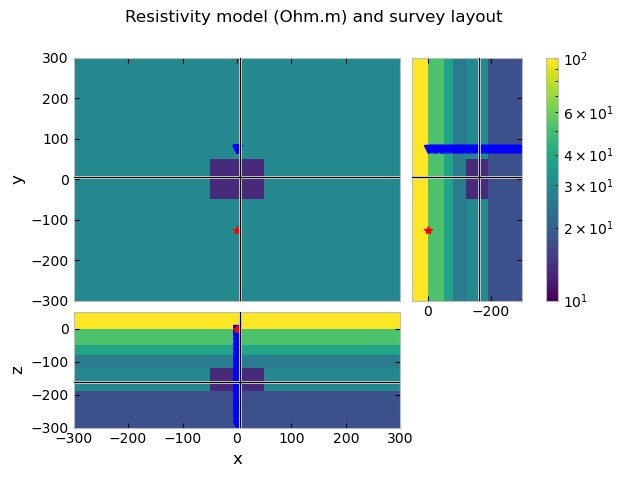

In [241]:
#QC cube location
grid.plot_3d_slicer(
    model_target2.property_x,
    pcolor_opts={'norm': LogNorm(vmin=10, vmax=100)},
    xlim=[-300, 300],
    ylim=[-300, 300],
    zlim=[-300, 50],
    zslice=-160,
)
# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

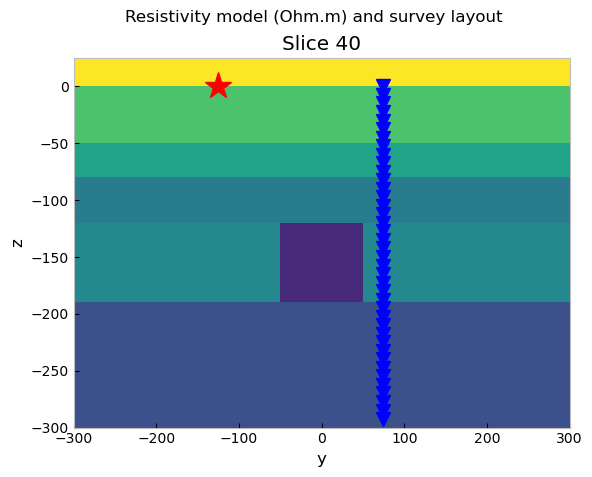

In [242]:
#Focus on the y,z plane
grid.plot_slice(
    model_target2.property_x,
    normal = 'X',
    pcolor_opts={'norm': LogNorm(vmin=10, vmax=100)},
    range_x=[-300, 300],
    range_y=[-300, 25],
#    slice_loc=0
)
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
axs[1].plot(rec_coords[1], rec_coords[2], 'bv', markersize = 10)
axs[1].plot(src_coords[1], src_coords[2], 'r*', markersize = 20)
axs[1].grid(False)

### Emg3d simulation

Takes +/- 16 minutes

In [243]:
#Generate source field
sfield = emg3d.fields.get_source_field(grid, source=source, frequency=frequency)

In [244]:
# Cuboid target
efield3D_target2 = emg3d.solve(model_target2, sfield, verb=2)

:: emg3d :: 8.9e-07; 4(24); 0:16:12; CONVERGED


In [245]:
# Cuboid target
resp_E_target2_3D = efield3D_target2.get_receiver(receivers, 'linear')

### Plots

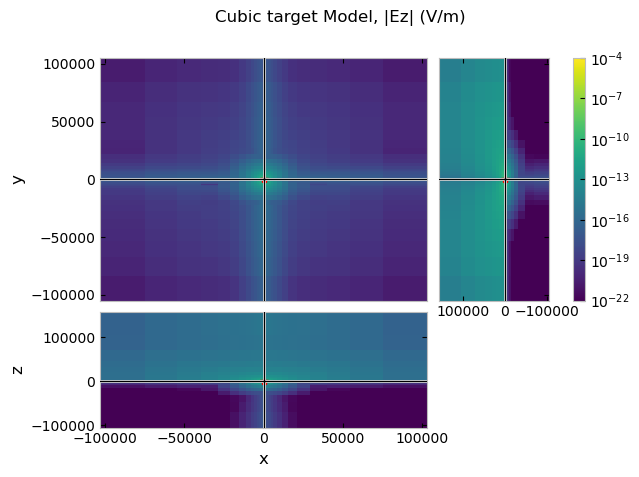

In [249]:
#Plot in the entire domain

grid.plot_3d_slicer(
    efield3D_target2.fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-22, vmax=1e-4)},
    zslice = -160
)
fig = plt.gcf()
fig.suptitle('Cubic target Model, |Ez| (V/m)')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

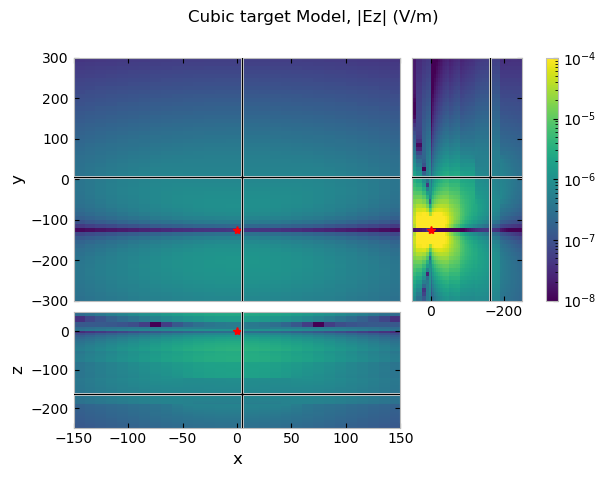

In [250]:
#Plot in the inner domain

grid.plot_3d_slicer(
    efield3D_target2.fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-4)},
    xlim=[-150, 150],
    ylim=[-300, 300],
    zlim=[-250, 50],
    zslice=-160,
)
# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Cubic target Model, |Ez| (V/m)')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

[0, -300, -250] [0, 300, 0]
x position:  -1.759303813742008e-11
y_bounds:  -299.99999999999443  ,  290.00000000000557
z_bounds:  -247.49999999999577  ,  -2.499999999995765
[0, -300, -250] [0, 300, 0]
x position:  -1.759303813742008e-11
y_bounds:  -299.99999999999443  ,  290.00000000000557
z_bounds:  -247.49999999999577  ,  -2.499999999995765


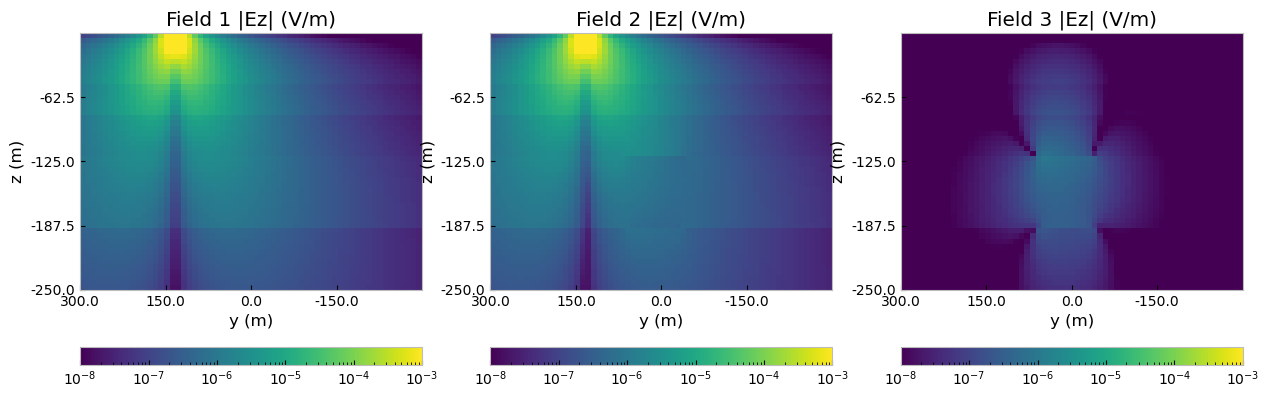

In [309]:
#Cubic plume model

efield1 = crop_to_domain(efield3D_base, grid, x_slice = 0, y_extent=300, zmin=-250, zmax=0)
efield2 = crop_to_domain(efield3D_target2, grid, x_slice = 0, y_extent=300, zmin=-250, zmax=0)
efield3 = np.abs(efield2)-np.abs(efield1)

manual_plot_slice_3x(efield1, efield2, efield3, y_extent=-300, zmin=-250, zmax=0, size_y = 6.4, size_z = 4.8, vmin = 1e-8, vmax = 1e-3)

(0.005086908146917177+1.4366308014329053e-05j) (0.05196765860596932+2.4229497288220085e-05j)


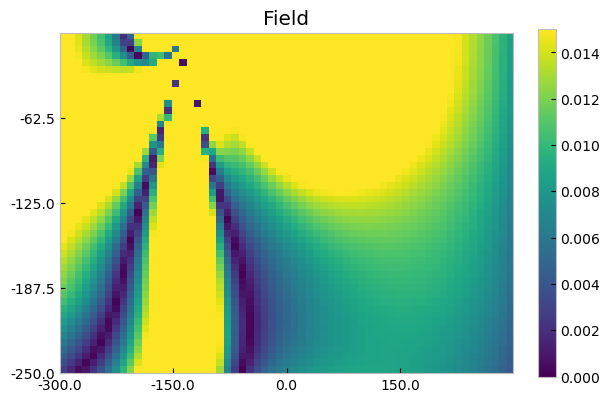

In [374]:
# Visualize relative difference

efield = efield3/efield1
print(min(efield[:,30]), max(efield[:,30]))

manual_plot_slice(efield, grid, y_extent=300, zmin=-250, zmax=0, size_y = 6.4, size_z = 4.8, vmin = 0, vmax = 0.015, norm = 'linear')

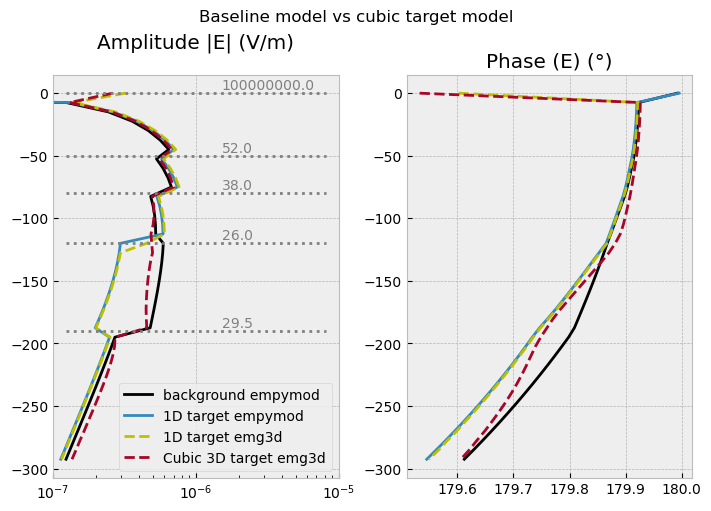

In [383]:
# Plot it
fig3, (ax31, ax32) = plt.subplots(1, 2, figsize=(7, 5), constrained_layout=True)

fig3.suptitle("Baseline model vs cubic target model")

ax31.set_title('Amplitude |E| (V/m)')
ax31.plot(resp_E_base.amp(), -offsets, 'k', label='background empymod')
ax31.plot(resp_E_target1.amp(), -offsets, 'C0-', label='1D target empymod')
ax31.plot(resp_E_target1_3D.amp(), -offsets, 'y--', label='1D target emg3d') # scale your emg3d amplitues by the source length
ax31.plot(resp_E_target2_3D.amp(), -offsets, 'C1--', label='Cubic 3D target emg3d') # scale your emg3d amplitues by the source length
ax31.set_xscale('log')
ax31.set_xlim([1e-7, 1e-5])
ax31.legend()

ax32.set_title('Phase (E) (°)')
ax32.plot(resp_E_base.pha(deg=True), -offsets, 'k')
ax32.plot(resp_E_target1.pha(deg=True), -offsets, 'C0-')
ax32.plot(resp_E_target1_3D.pha(deg=True), -offsets, 'y--')
ax32.plot(resp_E_target2_3D.pha(deg=True), -offsets, 'C1--')

ax33 = ax31.twiny()
#ax33.set_title('Model rho (Ohmm)')
#ax33.plot([75, 52.0, 52.0, 38.0, 38.0, 26.0, 26.0, 29.5, 29.5, 17.5, 17.5], [0, 0, -50, -50, -80, -80, -120, -120, -190, -190, -300], 'gray', ls='-')
ax33.hlines(depth, 0, 1, color='gray', ls=':', zorder=-1)
for i in np.arange(len(depth)):
    ax33.text(0.6, depth[i]+3, str(resistivities_base[i]), color='gray')
ax33.set_axis_off()

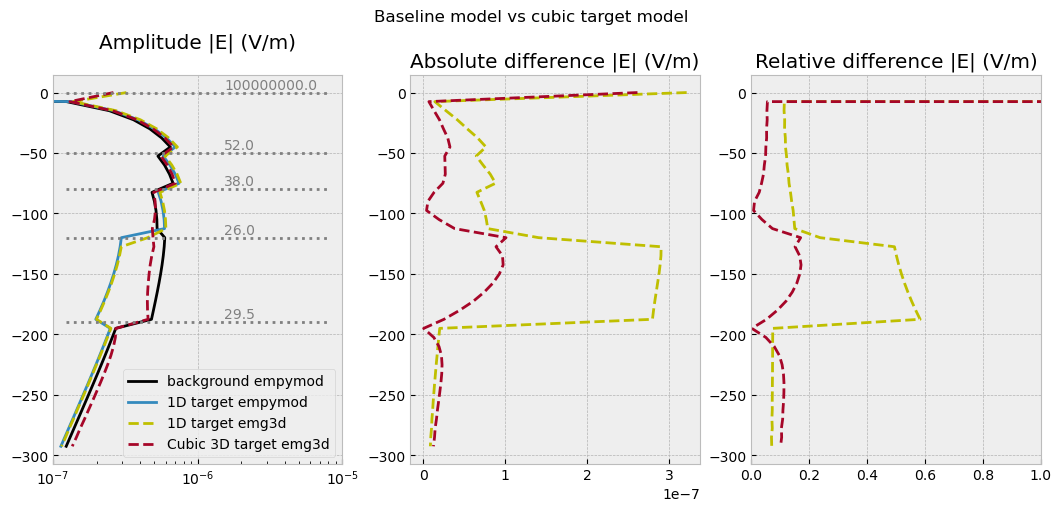

In [389]:
# Plot it
fig3, (ax31, ax32, ax33) = plt.subplots(1, 3, figsize=(10.5, 5), constrained_layout=True)

fig3.suptitle("Baseline model vs cubic target model")

ax31.set_title('Amplitude |E| (V/m)')
ax31.plot(resp_E_base.amp(), -offsets, 'k', label='background empymod')
ax31.plot(resp_E_target1.amp(), -offsets, 'C0-', label='1D target empymod')
ax31.plot(resp_E_target1_3D.amp(), -offsets, 'y--', label='1D target emg3d') # scale your emg3d amplitues by the source length
ax31.plot(resp_E_target2_3D.amp(), -offsets, 'C1--', label='Cubic 3D target emg3d') # scale your emg3d amplitues by the source length
ax31.set_xscale('log')
ax31.set_xlim([1e-7, 1e-5])
ax31.legend()

ax32.set_title('Absolute difference |E| (V/m)')
ax32.plot(np.abs(resp_E_target1_3D.amp()-resp_E_base.amp()), -offsets, 'y--')
ax32.plot(np.abs(resp_E_target2_3D.amp()-resp_E_base.amp()), -offsets, 'C1--')

ax33.set_title('Relative difference |E| (V/m)')
ax33.plot(np.abs((resp_E_target1_3D.amp()-resp_E_base.amp())/resp_E_base.amp()), -offsets, 'y--')
ax33.plot(np.abs((resp_E_target2_3D.amp()-resp_E_base.amp())/resp_E_base.amp()), -offsets, 'C1--')
ax33.set_xlim([0, 1])

ax34 = ax31.twiny()
#ax33.set_title('Model rho (Ohmm)')
#ax33.plot([75, 52.0, 52.0, 38.0, 38.0, 26.0, 26.0, 29.5, 29.5, 17.5, 17.5], [0, 0, -50, -50, -80, -80, -120, -120, -190, -190, -300], 'gray', ls='-')
ax34.hlines(depth, 0, 1, color='gray', ls=':', zorder=-1)
for i in np.arange(len(depth)):
    ax34.text(0.6, depth[i]+3, str(resistivities_base[i]), color='gray')
ax34.set_axis_off()

## Simulation of custom hot plume

### Create target model

#### Inserting the plume - SKIP if plume file is saved

In [164]:
#Use predefined function to insert a cuboid inton the target layer

x_extent = 150
y_extent = 150
zmin = depth[4]
zmax = depth[3]
res_QC = 13.1 #now: aquifer +50 °Celsius

res_QC = change_cuboid_resistivity(res_base.copy(), grid, x_extent, y_extent, zmin, zmax, res_target)

model_QC = emg3d.Model(grid, property_x=res_QC, mapping='Resistivity')

[-150, -150, -190] [150, 150, -120]
x bounds:  -145.0000000000176  ,  144.9999999999824
y_bounds:  -144.99999999999443  ,  145.00000000000557
z_bounds:  -187.49999999999577  ,  -117.49999999999577


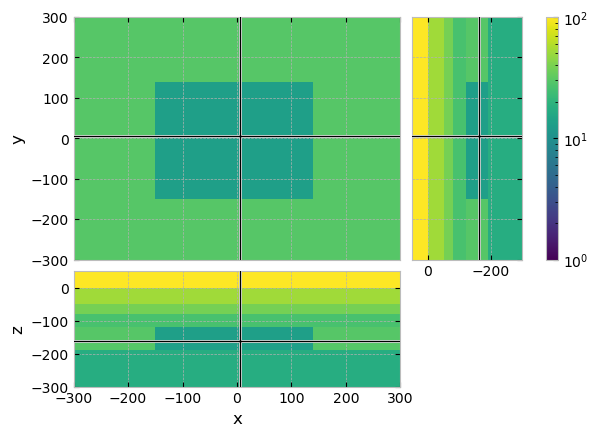

In [165]:
#QC cube location
grid.plot_3d_slicer(
    model_QC.property_x,
    pcolor_opts={'norm': LogNorm(vmin=1, vmax=100)},
    xlim=[-300, 300],
    ylim=[-300, 300],
    zlim=[-300, 50],
    zslice=-160,
)
fig = plt.gcf()

- Below we import temperature values from COMSOL for a buoyant plume.
- The relationship rho_hot = rho_cold/(1+0.020(T_hot-T_cold)) is assumed

In [413]:
#insert custom hot plume values [SKIP TO NEXT STEP IF RES FILE IS ALREADY SAVED]

#Load custom plume data
comsol_plume = np.loadtxt('test_plume_2.txt', skiprows=8) #data columns: radius, depth, temperature (K)

#crop data array to limit interpolation time
plume_crop = []
for i in np.arange(len(comsol_plume[:,0])):
    if comsol_plume[i,0] < 150 and comsol_plume[i,1] > depth[4] and comsol_plume[i,1] < depth[3]:
        plume_crop.append(comsol_plume[i])

ix_min, iy_min, iz_min, ix_max, iy_max, iz_max = find_cuboid_indeces_xyz(grid, x_extent, y_extent, zmin, zmax)

#interpolate temperature values and insert into 1d custom plume array
#To prevent edge effects, we assume that the min. temperature in the custom plume array is the original temperature of the aquifer before injection
rho_cold = resistivities_base[4]
T_cold = min(np.array(plume_crop)[:,2])
res_target3 = res_base.copy()
for ix in np.arange(ix_min, ix_max+1):
    for iy in np.arange(iy_min, iy_max+1):
        for iz in np.arange(iz_min, iz_max+1):
            loc = [grid.cell_centers_x[ix], grid.cell_centers_y[iy], grid.cell_centers_z[iz]] #select a cell coordinate from our grid
            radius = np.sqrt(loc[0]**2+loc[1]**2)
            loc2d = np.array([radius, loc[2]]) #flatten to 2d coordinates
            T_hot = plume_crop[interpolate2d(loc2d, plume_crop)][2] #find temperature value of COMSOL data point closest to this cell
            res_target3[ix, iy, iz] = rho_cold/(1+0.020*(T_hot-T_cold)) #translate to resistivity

#Save as new file in flattened form
np.savetxt('test_plume_2_interpolated.txt', res_target3.ravel('F'))

[-50, -50, -190] [50, 50, -120]


#### Load desired plume file

Possible plumes to use:
- 'test_plume_1_interpolated.txt': a small plume that reflects ... day injection in the default aquifer used by Gao et al.
- 'test_plume_2_interpolated.txt': a large plume that reflects ... day injection in the default aquifer used by Gao et al.

In [414]:
#load existing custom plume resistivities
res_target3 = np.loadtxt('test_plume_2_interpolated.txt')
print(np.shape(res_plume))

model_target3 = emg3d.Model(grid, property_x=res_target3, mapping='Resistivity')

(983040,)


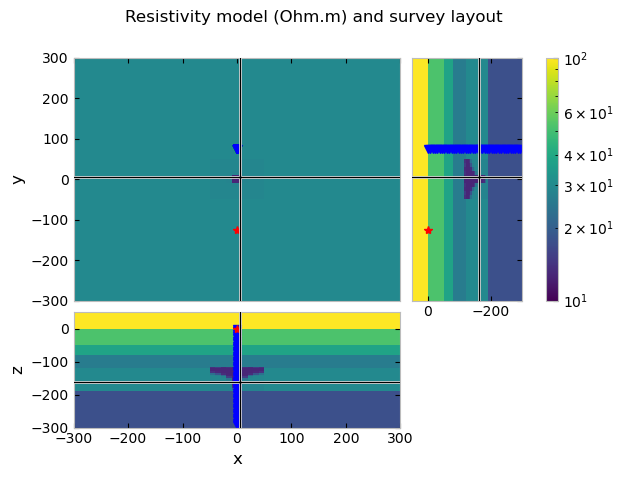

In [415]:
# Plot/QC the model with the 3D target
grid.plot_3d_slicer(
    model_target3.property_x,
    pcolor_opts={'norm': LogNorm(vmin=10, vmax=100)},
    xlim=[-300, 300],
    ylim=[-300, 300],
    zlim=[-300, 50],
    zslice=-160,
)
# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

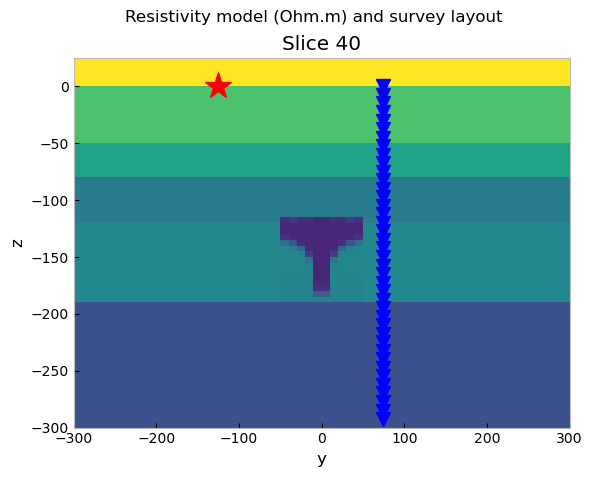

In [416]:
#Focus on the y,z plane
grid.plot_slice(
    model_target3.property_x,
    normal = 'X',
    pcolor_opts={'norm': LogNorm(vmin=10, vmax=100)},
    range_x=[-300, 300],
    range_y=[-300, 25],
#    slice_loc=0
)
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
axs[1].plot(rec_coords[1], rec_coords[2], 'bv', markersize = 10)
axs[1].plot(src_coords[1], src_coords[2], 'r*', markersize = 20)
axs[1].grid(False)

### Emg3d simulation

In [417]:
#Generate source field
sfield = emg3d.fields.get_source_field(grid, source=source, frequency=frequency)

In [418]:
# Cuboid target
efield3D_target3 = emg3d.solve(model_target3, sfield, verb=2)

:: emg3d :: 9.8e-07; 4(24); 4:05:10; CONVERGED


In [419]:
# Layered base
resp_E_target3_3D = efield3D_target3.get_receiver(receivers, 'linear')

### Plots

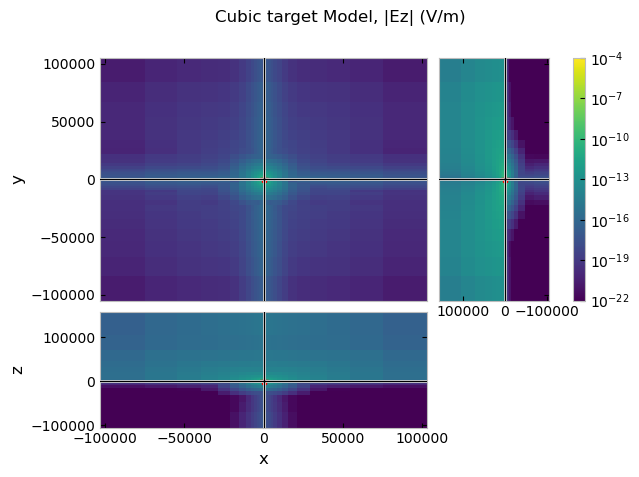

In [420]:
#Plot in the entire domain

grid.plot_3d_slicer(
    efield3D_target3.fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-22, vmax=1e-4)},
    zslice = -160
)
fig = plt.gcf()
fig.suptitle('Cubic target Model, |Ez| (V/m)')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

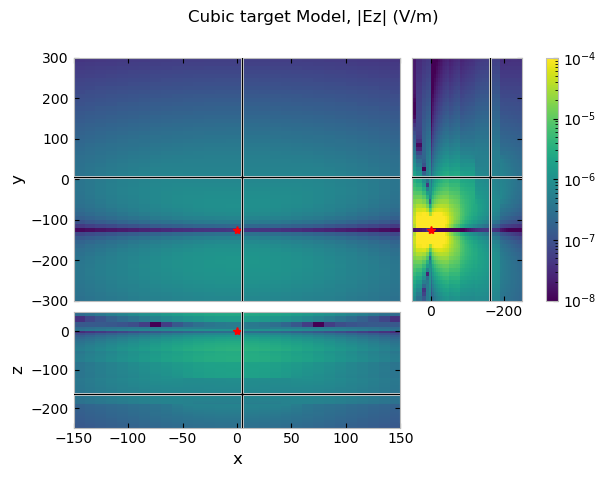

In [421]:
#Plot in the inner domain

grid.plot_3d_slicer(
    efield3D_target2.fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-4)},
    xlim=[-150, 150],
    ylim=[-300, 300],
    zlim=[-250, 50],
    zslice=-160,
)
# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Cubic target Model, |Ez| (V/m)')
axs = fig.get_children()
rec_coords = receivers
src_coords = source
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

[0, -300, -250] [0, 300, 0]
x position:  -1.759303813742008e-11
y_bounds:  -299.99999999999443  ,  300.00000000000557
z_bounds:  -247.49999999999577  ,  -2.499999999995765
[0, -300, -250] [0, 300, 0]
x position:  -1.759303813742008e-11
y_bounds:  -299.99999999999443  ,  300.00000000000557
z_bounds:  -247.49999999999577  ,  -2.499999999995765


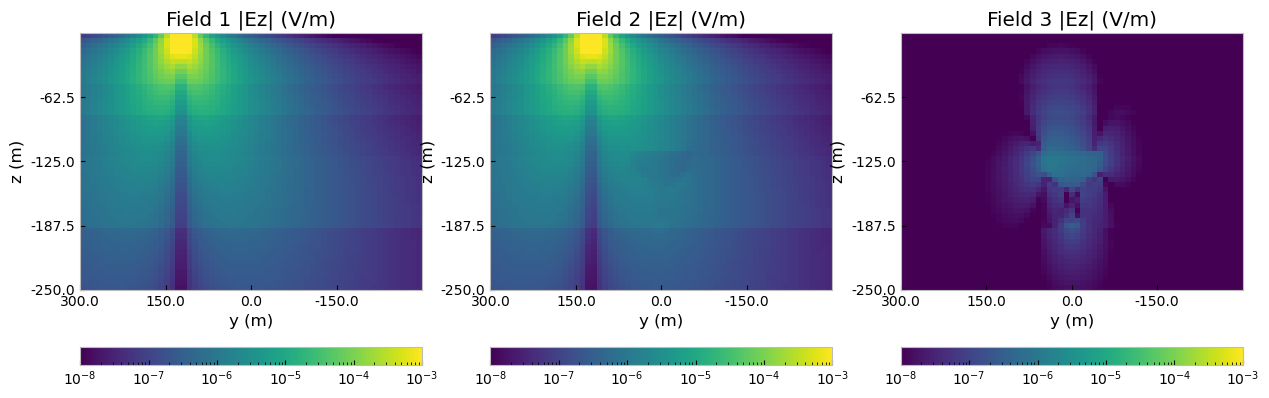

In [422]:
#Custom plume model

efield1 = crop_to_domain(efield3D_base, grid, x_slice = 0, y_extent=300, zmin=-250, zmax=0)
efield2 = crop_to_domain(efield3D_target3, grid, x_slice = 0, y_extent=300, zmin=-250, zmax=0)
efield3 = np.abs(efield2)-np.abs(efield1)

manual_plot_slice_3x(efield1, efield2, efield3, y_extent=-300, zmin=-250, zmax=0, size_y = 6.4, size_z = 4.8, vmin = 1e-8, vmax = 1e-3)

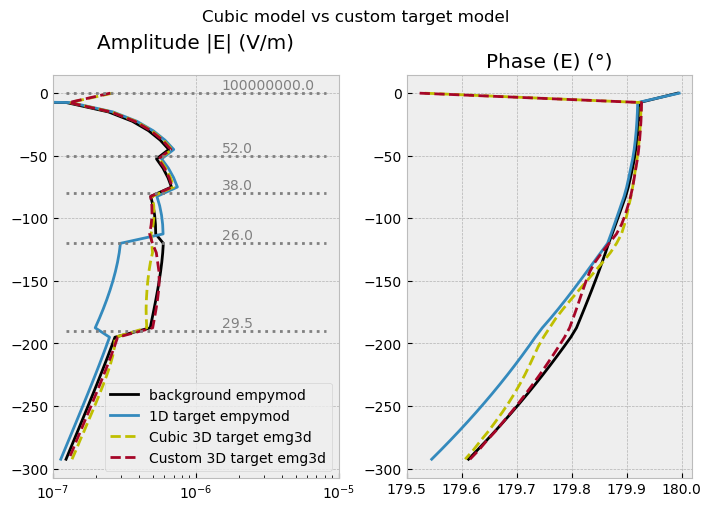

In [423]:
# Plot it
fig3, (ax31, ax32) = plt.subplots(1, 2, figsize=(7, 5), constrained_layout=True)

fig3.suptitle("Cubic model vs custom target model")

ax31.set_title('Amplitude |E| (V/m)')
ax31.plot(resp_E_base.amp(), -offsets, 'k', label='background empymod')
ax31.plot(resp_E_target1.amp(), -offsets, 'C0-', label='1D target empymod')
ax31.plot(resp_E_target2_3D.amp(), -offsets, 'y--', label='Cubic 3D target emg3d') # scale your emg3d amplitues by the source length
ax31.plot(resp_E_target3_3D.amp(), -offsets, 'C1--', label='Custom 3D target emg3d') # scale your emg3d amplitues by the source length
ax31.set_xscale('log')
ax31.set_xlim([1e-7, 1e-5])
ax31.legend()

ax32.set_title('Phase (E) (°)')
ax32.plot(resp_E_base.pha(deg=True), -offsets, 'k')
ax32.plot(resp_E_target1.pha(deg=True), -offsets, 'C0-')
ax32.plot(resp_E_target2_3D.pha(deg=True), -offsets, 'y--')
ax32.plot(resp_E_target3_3D.pha(deg=True), -offsets, 'C1--')

ax33 = ax31.twiny()
#ax33.set_title('Model rho (Ohmm)')
#ax33.plot([75, 52.0, 52.0, 38.0, 38.0, 26.0, 26.0, 29.5, 29.5, 17.5, 17.5], [0, 0, -50, -50, -80, -80, -120, -120, -190, -190, -300], 'gray', ls='-')
ax33.hlines(depth, 0, 1, color='gray', ls=':', zorder=-1)
for i in np.arange(len(depth)):
    ax33.text(0.6, depth[i]+3, str(resistivities_base[i]), color='gray')
ax33.set_axis_off()

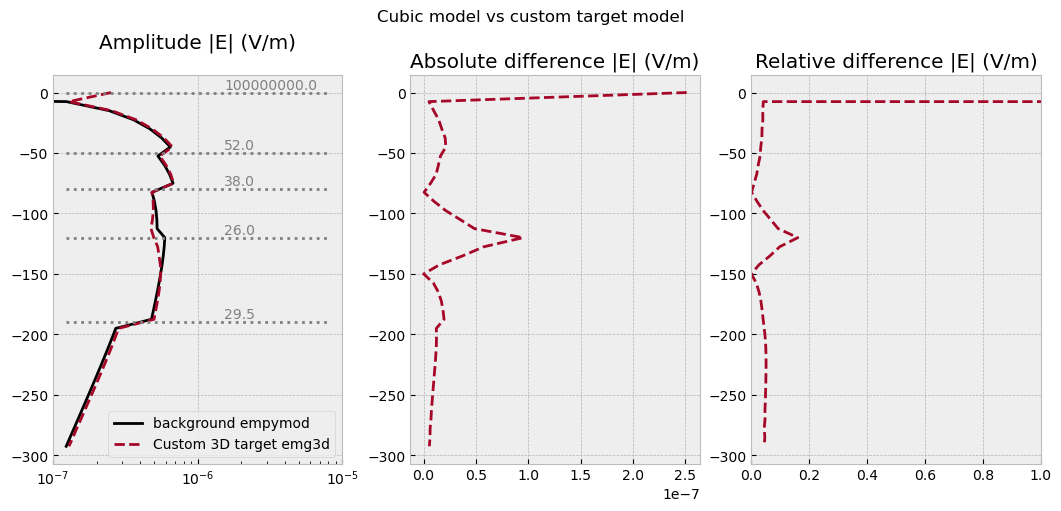

In [424]:
# Plot it
fig3, (ax31, ax32, ax33) = plt.subplots(1, 3, figsize=(10.5, 5), constrained_layout=True)

fig3.suptitle("Cubic model vs custom target model")

ax31.set_title('Amplitude |E| (V/m)')
ax31.plot(resp_E_base.amp(), -offsets, 'k', label='background empymod')
#ax31.plot(resp_E_target1.amp(), -offsets, 'C0-', label='1D target empymod')
#ax31.plot(resp_E_target2_3D.amp(), -offsets, 'y--', label='Cubic 3D target emg3d') # scale your emg3d amplitues by the source length
ax31.plot(resp_E_target3_3D.amp(), -offsets, 'C1--', label='Custom 3D target emg3d') # scale your emg3d amplitues by the source length
ax31.set_xscale('log')
ax31.set_xlim([1e-7, 1e-5])
ax31.legend()

ax32.set_title('Absolute difference |E| (V/m)')
#ax32.plot(np.abs(resp_E_target2_3D.amp()-resp_E_base.amp()), -offsets, 'y--')
ax32.plot(np.abs(resp_E_target3_3D.amp()-resp_E_base.amp()), -offsets, 'C1--')

ax33.set_title('Relative difference |E| (V/m)')
#ax33.plot(np.abs((resp_E_target2_3D.amp()-resp_E_base.amp())/resp_E_base.amp()), -offsets, 'y--')
ax33.plot(np.abs((resp_E_target3_3D.amp()-resp_E_base.amp())/resp_E_base.amp()), -offsets, 'C1--')
ax33.set_xlim([0, 1])

ax34 = ax31.twiny()
#ax33.set_title('Model rho (Ohmm)')
#ax33.plot([75, 52.0, 52.0, 38.0, 38.0, 26.0, 26.0, 29.5, 29.5, 17.5, 17.5], [0, 0, -50, -50, -80, -80, -120, -120, -190, -190, -300], 'gray', ls='-')
ax34.hlines(depth, 0, 1, color='gray', ls=':', zorder=-1)
for i in np.arange(len(depth)):
    ax34.text(0.6, depth[i]+3, str(resistivities_base[i]), color='gray')
ax34.set_axis_off()

In [ ]:
emg3d.Report()